## Assignment 02 
Name - **D.M.S.S.Dissanayake**   
Index No - **190155L**

In [147]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import random
import cv2 as cv

N = 100
half_n = N// 2
r = 10
s = r/16
t = np.random.uniform (0 , 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r+n)*np.cos(t), (r+n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12 ,half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line ))



In [222]:
def RANSAC_circle(Data_set,No_of_iterations,t):
    max_inlinear_count=0
    best_fit_circle_coefficient=[]
    best_sample_points=[]
    
    for sample in range(0,No_of_iterations+1):
        point1,point2,point3=random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1)
        x1,x2,x3=Data_set[point1][0],Data_set[point2][0],Data_set[point3][0]
        y1,y2,y3=Data_set[point1][1],Data_set[point2][1],Data_set[point3][1]

        P = np.array([[2*x1 , 2*y1 , 1] , [2*x2 , 2*y2 , 1] , [2*x3 , 2*y3 , 1]])
        if (np.linalg.det(P)==0):continue
        K=np.array([[x1**2 + y1**2] , [x2**2 + y2**2] , [x3**2+y3**2]])*(-1)
        answer=np.linalg.inv(P)@ K
        g,f,c=answer[0][0],answer[1][0],answer[2][0]
        radius=np.sqrt(g**2+f**2-c)

        if radius>20: continue
        center=[-g,-f]
        
        inlinear_count=0
        for i in range(0,len(Data_set)): # Counting the no.of inliers for the circle from sample points
            distance=abs(np.sqrt((Data_set[i][0]-center[0])**2 + (Data_set[i][1]-center[1])**2) - radius)
            if distance < t:
                inlinear_count+=1
        if inlinear_count>max_inlinear_count: 
            max_inlinear_count=inlinear_count
            best_fit_circle_coefficient=[g,f,c]
            best_sample_points=np.array([Data_set[point1],Data_set[point2],Data_set[point3]])
    return(best_fit_circle_coefficient,best_sample_points,max_inlinear_count)

In [224]:
s,t,e,p=3,1,0.5,0.99 # s = sample points , t = threshold for inliers, e = outlier ratio
No_of_iterations=int(np.log(1-p)/np.log(1-(1-e)**s))
ransac_circle_coeff,ransac_sample,ransac_inlinear_count=RANSAC_circle(X,No_of_iterations,t)
F,G,C=ransac_circle_coeff[0],ransac_circle_coeff[1],ransac_circle_coeff[2]
R=np.sqrt(G**2+F**2-C)

In,Out=[],[]
for point in X:
    d=abs(np.sqrt((point[0]+G)**2+(point[1]+F)**2)-R)
    if d<t: In.append(point)
    else:Out.append(point)

Inlin = np.array(In).T
Outlin = np.array(Out).T
Samp = ransac_sample.T
print("Number of Itarations =",No_of_iterations)
print("RANSAC Estimated circle Inlinear Count =",ransac_inlinear_count)   

Number of Itarations = 34
RANSAC Estimated circle Inlinear Count = 45


In [227]:
best_circle_coeff,best_sample,best_inlinear_count=RANSAC_circle(X,1000,t)
best_F,best_G,best_C=best_circle_coeff[0],best_circle_coeff[1],best_circle_coeff[2]
best_R=np.sqrt(best_G**2+best_F**2-best_C)
bestt_sample=best_sample.T
print("best fitting circle Inlinear Count =",best_inlinear_count)

best fitting circle Inlinear Count = 52


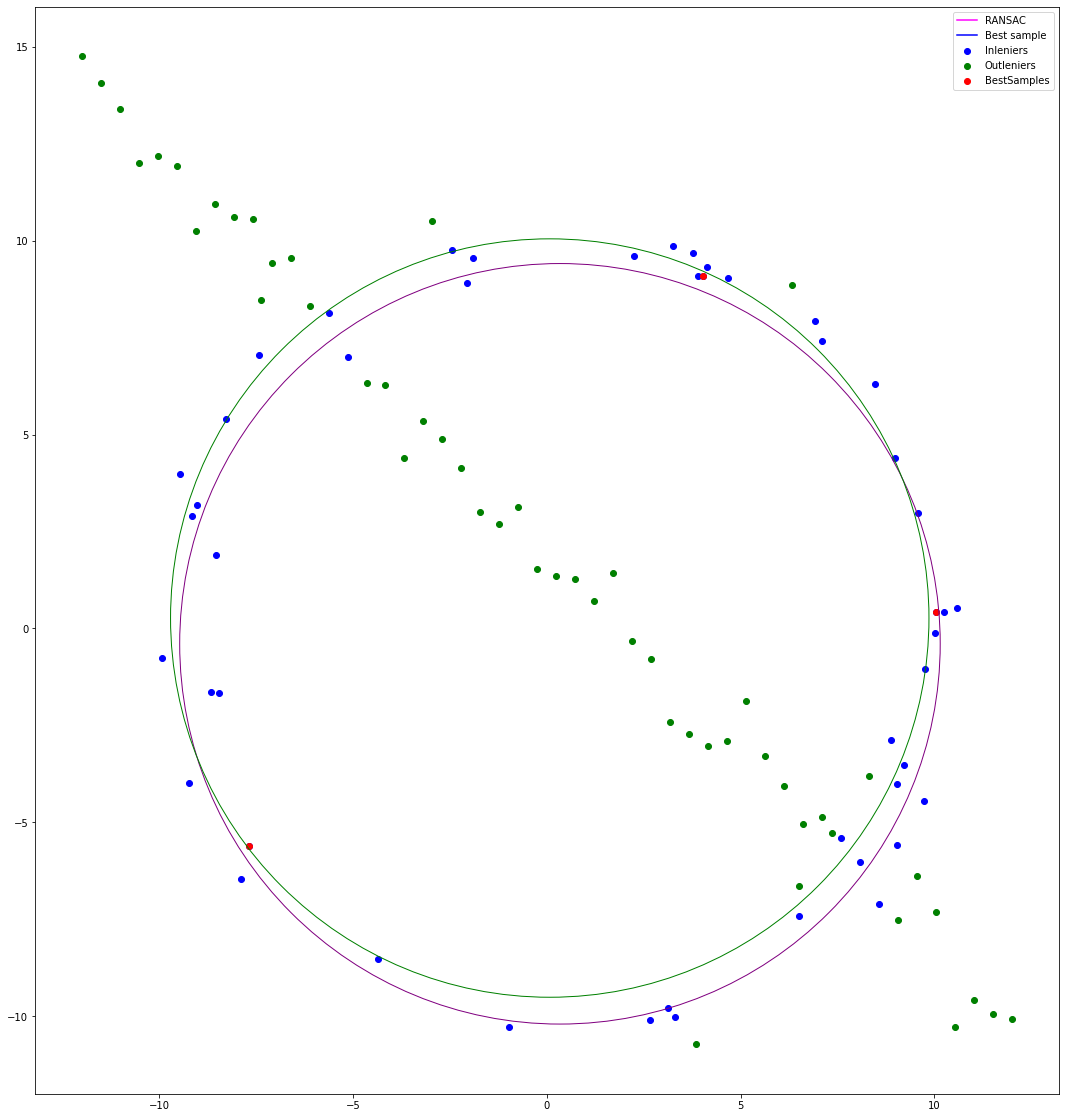

In [226]:
#plotting

figure, ax = plt.subplots( 1, figsize=(20,20) )

ransac_circle = plt.Circle((-G,-F), R, fill=False, color="purple" ,label="RANSAC")
best_fitting_circle = plt.Circle((-best_G,-best_F), best_R, fill=False, color="green" ,label="Best Fitting")

ax.scatter(Inlin[0],Inlin[1], color="blue" , label="Inleniers")
ax.scatter(Outlin[0],Outlin[1], color="green" , label="Outleniers")
ax.scatter(bestt_sample[0] ,bestt_sample[1], color="red" , label="BestSamples")
ax.plot(-G,-F,color="magenta", label = "RANSAC")
ax.plot(-best_G,-best_F,color="blue", label = "Best sample")
ax.set_aspect( 1 )
ax.add_artist( ransac_circle )
ax.add_artist( best_fitting_circle )
plt.legend()
plt.show()

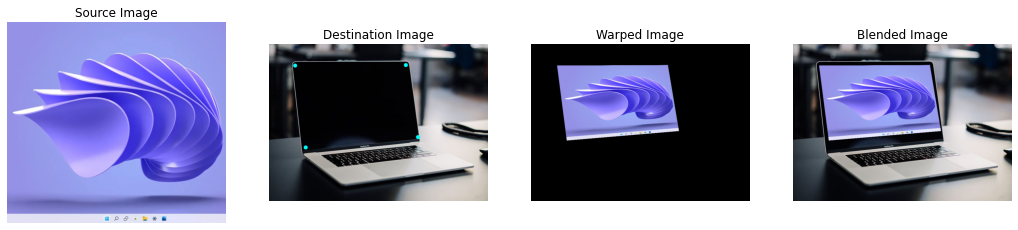

In [221]:
# Question 2

def corner_points(img):
    # Returns the corner pixels of the image
    pts = []
    pts.append([0,0])
    pts.append([img_src.shape[1]-1,0])
    pts.append([0,img_src.shape[1]-1])
    pts.append([img_src.shape[1]-1,img_src.shape[1]-1])
    return pts

def draw_circle(event, x, y, flags, param):
    # Draw circle on the selected points on the image
   global pts_dst
   if event == cv.EVENT_LBUTTONDOWN:
        pts_dst.append((x, y))
        cv.circle(img_dst, (x, y), 8, (255, 255, 0), -1)

img_dst = cv.imread('macbook.jpg',cv.IMREAD_COLOR)
img_src = cv.imread('windowswallpaper.jpg',cv.IMREAD_COLOR)

pts_src = np.array(corner_points(img_src))
pts_dst = []

cv.namedWindow('image')
cv.setMouseCallback('image',draw_circle)
cv.imshow('image', img_dst)
cv.waitKey(0)
cv.destroyAllWindows()

pts_dst = np.array(pts_dst) 
# Calculate Homography
h, status = cv.findHomography(pts_src, pts_dst)
# Warp source image to destination based on homography
img_warped = cv.warpPerspective(img_src, h, (img_dst.shape[1],img_dst.shape[0]))
img_blended = cv.addWeighted(img_warped, 1, cv.imread('macbook.jpg',cv.IMREAD_COLOR), 1, 0.0)

fig,ax = plt.subplots(1,4,figsize=(18,6))
ax[0].imshow(cv.cvtColor(img_src, cv.COLOR_BGR2RGB))
ax[0].set_title('Source Image')
ax[1].imshow(cv.cvtColor(img_dst, cv.COLOR_BGR2RGB))
ax[1].set_title('Destination Image')
ax[2].imshow(cv.cvtColor(img_warped, cv.COLOR_BGR2RGB))
ax[2].set_title('Warped Image')
ax[3].imshow(cv.cvtColor(img_blended, cv.COLOR_BGR2RGB))
ax[3].set_title('Blended Image')
for i in range(2):
    for j in range(2):
        ax[i,j].axis('off')
plt.show()


(-0.5, 799.5, 532.5, -0.5)

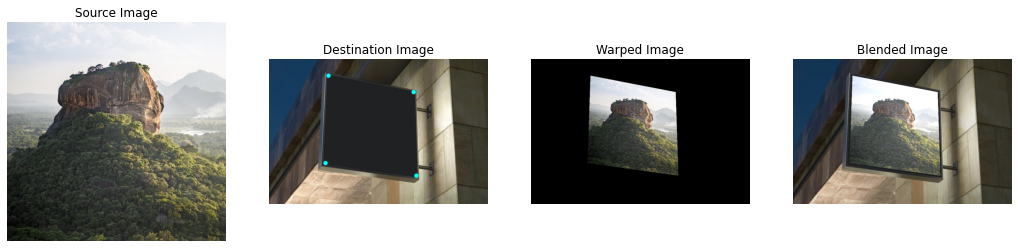

In [169]:
img_src = cv.imread('travelsrilanka.jpg',cv.IMREAD_COLOR)
img_dst = cv.imread('signboard.jpg',cv.IMREAD_COLOR)

def corner_points(img):
    pts = []
    pts.append([0,0])
    pts.append([img_src.shape[1]-1,0])
    pts.append([0,img_src.shape[1]-1])
    pts.append([img_src.shape[1]-1,img_src.shape[1]-1])
    return pts

def draw_circle(event, x, y, flags, param):
   global pts_dst
   if event == cv.EVENT_LBUTTONDOWN:
        pts_dst.append((x, y))
        cv.circle(img_dst, (x, y), 8, (255, 255, 0), -1)

pts_src = np.array(corner_points(img_src))
pts_dst = []

cv.namedWindow('image')
cv.setMouseCallback('image',draw_circle)
cv.imshow('image', img_dst)
cv.waitKey(0)
cv.destroyAllWindows()

pts_dst = np.array(pts_dst) 
# Calculate Homography
h, status = cv.findHomography(pts_src, pts_dst)
# Warp source image to destination based on homography
img_warped = cv.warpPerspective(img_src, h, (img_dst.shape[1],img_dst.shape[0]))
img_blended = cv.addWeighted(img_warped,1 , cv.imread('signboard.jpg',cv.IMREAD_COLOR), 0.9, 0.0)

fig,ax = plt.subplots(1,4,figsize=(18,6))
ax[0].imshow(cv.cvtColor(img_src, cv.COLOR_BGR2RGB))
ax[0].set_title('Source Image')
ax[1].imshow(cv.cvtColor(img_dst, cv.COLOR_BGR2RGB))
ax[1].set_title('Destination Image')
ax[2].imshow(cv.cvtColor(img_warped, cv.COLOR_BGR2RGB))
ax[2].set_title('Warped Image')
ax[3].imshow(cv.cvtColor(img_blended, cv.COLOR_BGR2RGB))
ax[3].set_title('Blended Image')
for i in range(2):
    for j in range(2):
        ax[i,j].axis('off')
plt.show()

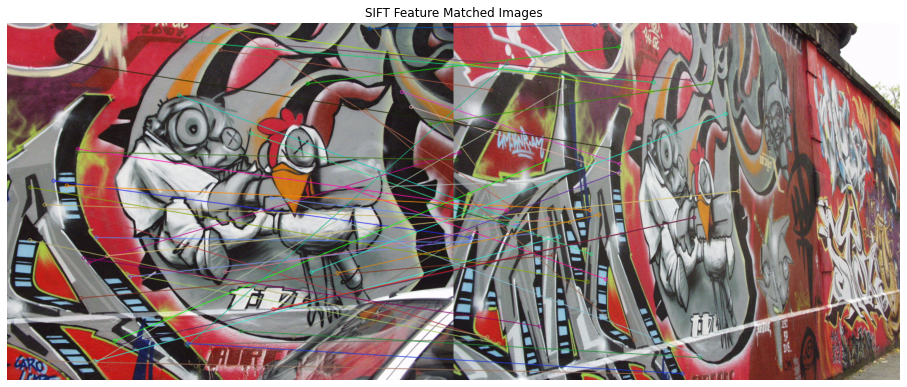

In [230]:
# Question 3

import numpy as np
import cv2 as cv
import matplotlib . pyplot as plt
import random 

img1 = cv.imread("img1.ppm")
img2 = cv.imread("img5.ppm")
img3 = cv.imread("img4.ppm")
# detect features from the image
sift = cv.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None) # detect features from the image
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None) # detect features from the image
#draw the detected key points
bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
matched_img = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)


plt.figure(figsize=(16,8))
plt.title('SIFT Feature Matched Images')
plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [288]:
import random as rnd

def sift_keypoint(src,dst):
    # Finding matched SIFT Keypoints between source & destination images
    sift = cv.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(src, None) 
    keypoints_2, descriptors_2 = sift.detectAndCompute(dst, None) 
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)
    list_kp1,list_kp2 = [],[]

    for mat in matches:
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx
        (x1, y1) = keypoints_1[img1_idx].pt
        (x2, y2) = keypoints_2[img2_idx].pt
        list_kp1.append((int(x1+0.5), int(y1+0.5)))
        list_kp2.append((int(x2+0.5), int(y2+0.5)))

    return(list_kp1,list_kp2)

def Homography_by_ransac(src,dst):
    # Find the best homography using RANSAC 
    N = 10000
    threshold = 0.3
    max_inlinears = 0
    H=[]
    src_keylist , dst_keylist = sift_keypoint(src,dst)
    src_keylist, dst_keylist = np.array(src_keylist) , np.array(dst_keylist)
   
    for samp in range(0,N):
        
        ind1  =rnd.randrange(0,len(src_keylist))
        ind2 = rnd.randrange(0,len(src_keylist))
        ind3 = rnd.randrange(0,len(src_keylist))
        ind4 = rnd.randrange(0,len(src_keylist))

        s_pt1 ,d_pt1 = src_keylist[ind1]  , dst_keylist[ind1]
        s_pt2 ,d_pt2 = src_keylist[ind2]  , dst_keylist[ind2]
        s_pt3 ,d_pt3 = src_keylist[ind3]  , dst_keylist[ind3]
        s_pt4 ,d_pt4 = src_keylist[ind4]  , dst_keylist[ind4]

        A = np.array([[ 0, 0, 0, -s_pt1[0], -s_pt1[1], -1, d_pt1[1]*s_pt1[0], d_pt1[1]*s_pt1[1], d_pt1[1]],
                      [ -s_pt1[0], -s_pt1[1], -1, 0, 0, 0, d_pt1[0]*s_pt1[0], d_pt1[0]*s_pt1[1], d_pt1[0]],
                      [ 0, 0, 0, -s_pt2[0], -s_pt2[1], -1, d_pt2[1]*s_pt2[0], d_pt2[1]*s_pt2[1], d_pt2[1]],
                      [ -s_pt2[0], -s_pt2[1], -1, 0, 0, 0, d_pt2[0]*s_pt2[0], d_pt2[0]*s_pt2[1], d_pt2[0]],
                      [ 0, 0, 0, -s_pt3[0], -s_pt3[1], -1, d_pt3[1]*s_pt3[0], d_pt3[1]*s_pt3[1], d_pt3[1]],
                      [ -s_pt3[0], -s_pt3[1], -1, 0, 0, 0, d_pt3[0]*s_pt3[0], d_pt3[0]*s_pt3[1], d_pt3[0]],
                      [ 0, 0, 0, -s_pt4[0], -s_pt4[1], -1, d_pt4[1]*s_pt4[0], d_pt4[1]*s_pt4[1], d_pt4[1]],
                      [ -s_pt4[0], -s_pt4[1], -1, 0, 0, 0, d_pt4[0]*s_pt4[0], d_pt4[0]*s_pt4[1], d_pt4[0]],
                      [0, 0, 0, 0, 0, 0, 0, 0, 1]])
 
        h = np.linalg.inv(A) @ np.array([[0,0,0,0,0,0,0,0,1]]).T
        h = np.reshape(h,(3,3))
        X = np.vstack([src_keylist.T , np.ones( (1, len(src_keylist)) )])
        transformed_keys = h @ X
        z= np.array([transformed_keys[-1]]).T
        transformed_keys = (transformed_keys[:2].T) / z
        #RANSAC Method
        inlinears_count = 0
        for  i in range(0 , len(transformed_keys)):
            distance = np.sqrt( (transformed_keys[i][0] - dst_keylist[i][0])**2 + (transformed_keys[i][1] - dst_keylist[i][1])**2 )
            if abs(distance) < threshold: inlinears_count += 1
        
        if inlinears_count > max_inlinears:
            max_inlinears = inlinears_count
            H = h
    return(H)

In [267]:
H1=Homography_by_ransac(img1,img3) # Compute homography between img1.ppm & img4.ppm
H2=Homography_by_ransac(img3,img2) # Compute homography between img4.ppm & img5.ppm
H=np.matmul(H2,H1) # Compute the homography between img1.ppm & img5.ppm


<ipython-input-248-c57118e853a1>:70: RuntimeWarning: divide by zero encountered in true_divide
  transformed_keys = (transformed_keys[:2].T) / z


Homography of the two images
 [[ 5.98115976e-01  4.36132140e-02  2.23687089e+02]
 [ 1.99927233e-01  1.13339066e+00 -1.99939424e+01]
 [ 4.50611153e-04 -4.78941765e-05  9.85864401e-01]]


In [295]:
Original_H = np.array([[6.2544644e-01, 5.7759174e-02, 2.2201217e+02],
   [2.2240536e-01, 1.1652147e+00, -2.5605611e+01],
  [4.9212545e-04, -3.6542424e-05, 1.0000000e+00]])
Error_H = H-Original_H

print('Homography of the two images\n',H)
print('Error by substracting with the Original Homography\n',Error_H)


Homography of the two images
 [[  0.59811598   0.04361321 223.68708894]
 [  0.19992723   1.13339066 -19.99394235]
 [  0.00045061  -0.00004789   0.9858644 ]]
Error by substracting with the Original Homography
 [[-0.02733046 -0.01414596  1.67491894]
 [-0.02247813 -0.03182404  5.61166865]
 [-0.00004151 -0.00001135 -0.0141356 ]]


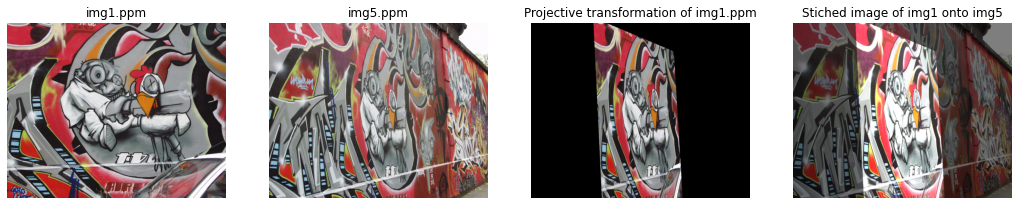

In [299]:
homograpy_im1= cv.warpPerspective(img1,H,(img2.shape[1], img2.shape[0]))
im1to5 = cv.addWeighted(homograpy_im1,1, img2, 0.5,0) # Stitch img1.ppm onto img5.ppm


fig,ax = plt.subplots(1,4,figsize=(18,6))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0].set_title('img1.ppm')
ax[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax[1].set_title('img5.ppm')
ax[2].imshow(cv.cvtColor(homograpy_im1, cv.COLOR_BGR2RGB))
ax[2].set_title('Projective transformation of img1.ppm')
ax[3].imshow(cv.cvtColor(im1to5, cv.COLOR_BGR2RGB))
ax[3].set_title('Stiched image of img1 onto img5')
for i in range(4):
        ax[i].axis('off')
plt.show()
